In [1]:
from astropy.io import fits
from PIL import Image as PILImage
import pylab as pl
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.models import Gaussian1D, Linear1D
from astropy.modeling.fitting import LinearLSQFitter
from IPython.display import Image
from astroquery.nist import Nist
import numpy as np
from astropy import units as u
pl.rcParams['image.origin'] = 'lower'
pl.matplotlib.style.use('dark_background')

In [2]:
hg_filename = "\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\BestGroup_Aug31\\lights_straight_up.FIT"
hy_filename = "\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\BestGroup_Aug31\\hydrogen.FIT"
he_filename = "\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\BestGroup_Aug31\\helium.FIT"
ne_filename = "\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\BestGroup_Aug31\\neon.FIT"
sun_filename = "\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\BestGroup_Aug31\\sun_10s.FIT"
hy1_filename = "\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\BestGroup_Aug31\\group1_hydrogen_10s.FIT"
hy2_filename = "\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\BestGroup_Aug31\\group2_hydrogen_10s.FIT"

In [3]:
ne_image = fits.getdata(ne_filename)
he_image = fits.getdata(he_filename)
h_image = fits.getdata(hy_filename)
lights_image = fits.getdata(hg_filename)

In [4]:
ne_spectrum = ne_image[350:450,:].mean(axis=0)
he_spectrum = he_image[350:450,:].mean(axis=0)
h_spectrum = h_image[350:450,:].mean(axis=0)
lights_spectrum = lights_image[350:450,:].mean(axis=0)

In [5]:
xaxis = np.arange(he_image.shape[1])

In [6]:
guessed_wavelengths_ne = [540, 535, 520, 518, 510, 507, 504]
guessed_xvals_ne = [80, 113, 187, 207, 220, 240, 260]

npixels = 10
improved_xval_guesses_ne = [np.average(xaxis[g-npixels:g+npixels],
                                    weights=ne_spectrum[g-npixels:g+npixels] - np.median(ne_spectrum))
                         for g in guessed_xvals_ne]
improved_xval_guesses_ne

[83.99439688492227,
 114.74226128407567,
 184.077164601371,
 206.42057442506083,
 220.5523215145684,
 239.62171566961243,
 260.0977554664349]

Text(0.5, 1.0, 'Neon and guess points')

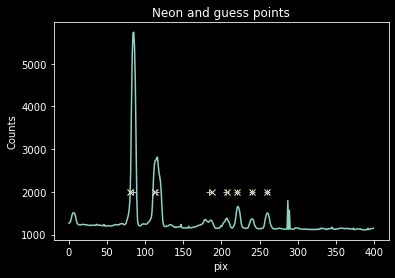

In [7]:
pl.plot(xaxis[0:400], ne_spectrum[0:400])
pl.plot(guessed_xvals_ne[0:400], [2000]*7, 'x')
pl.plot(improved_xval_guesses_ne[0:400], [2000]*7, '+');
pl.ylabel("Counts")
pl.xlabel("pix")
pl.title("Neon and guess points")

In [8]:
linfitter = LinearLSQFitter()
wlmodel = Linear1D()
linfit_wlmodel = linfitter(model=wlmodel, x=improved_xval_guesses_ne, y=guessed_wavelengths_ne)
wavelengths = linfit_wlmodel(xaxis) * u.nm
linfit_wlmodel

<Linear1D(slope=-0.2110209, intercept=558.61902513)>

Text(0.5, 1.0, 'Neon and improved guess points')

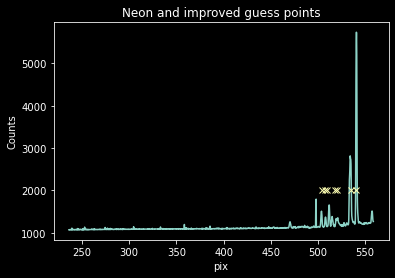

In [9]:
pl.plot(wavelengths, ne_spectrum)
pl.plot(guessed_wavelengths_ne, [2000]*7, 'x');
pl.ylabel("Counts")
pl.xlabel("pix")
pl.title("Neon and improved guess points")

Text(0.5, 1.0, 'Neon fit line')

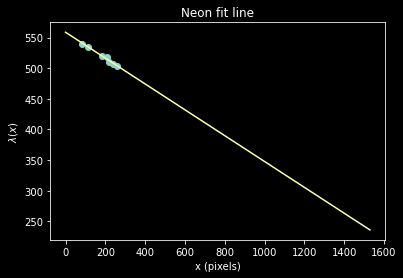

In [10]:
pl.plot(improved_xval_guesses_ne, guessed_wavelengths_ne, 'o')
pl.plot(xaxis, wavelengths, '-')
pl.ylabel("$\lambda(x)$")
pl.xlabel("x (pixels)")
pl.title("Neon fit line")

In [11]:
minwave = wavelengths.min()
maxwave = wavelengths.max()

hydrogen_lines = Nist.query(minwav=minwave,
                           maxwav=maxwave,
                           linename='H I')
helium_lines = Nist.query(minwav=minwave,
                           maxwav=maxwave,
                           linename='He I')
neon_lines = Nist.query(minwav=minwave,
                        maxwav=maxwave,
                        linename='Ne I')

Text(0.5, 1.0, 'Neon Spectra Overlay')

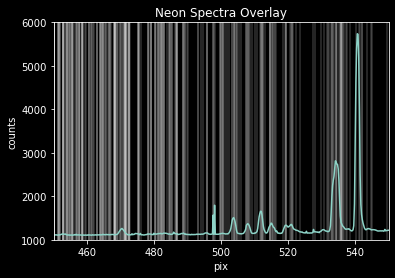

In [12]:
pl.plot(wavelengths, ne_spectrum)
pl.vlines(neon_lines['Observed'], 6000, 250, 'w', alpha=0.20);
pl.axis([450, 550, 1000, 6000])
pl.xlabel("pix")
pl.ylabel('counts')
pl.title('Neon Spectra Overlay')

In [13]:
ne_keep = np.array([('*' not in x) and ('f' not in x) for x in neon_lines['Rel.']])
ne_wl_tbl = neon_lines['Observed'][ne_keep]
ne_rel_tbl = np.array([float(x) for x in neon_lines['Rel.'][ne_keep]])

Text(0.5, 1.0, 'Neon and fit points')

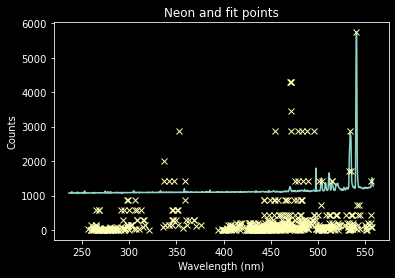

In [14]:
ne_rel_intens = ne_rel_tbl / ne_rel_tbl.max() * ne_spectrum.max()
pl.plot(wavelengths, ne_spectrum)
pl.plot(ne_wl_tbl, ne_rel_intens, 'x')
pl.xlabel('Wavelength (nm)');
pl.ylabel("Counts")
pl.title("Neon and fit points")

Text(0.5, 1.0, 'Neon and improved fit points')

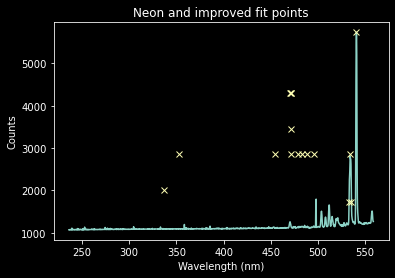

In [15]:
ne_keep_final = ne_rel_intens > 1500
pl.plot(wavelengths, ne_spectrum)
pl.plot(ne_wl_tbl[ne_keep_final], ne_rel_intens[ne_keep_final], 'x')
pl.xlabel('Wavelength (nm)');
pl.ylabel("Counts")
pl.title("Neon and improved fit points")

In [16]:
ne_wl_final = ne_wl_tbl[ne_keep_final]
ne_pixel_vals = linfit_wlmodel.inverse(ne_wl_final)

In [17]:
npixels = 10
improved_xval_guesses_ne = [np.average(xaxis[g-npixels:g+npixels],
                                    weights=ne_spectrum[g-npixels:g+npixels] - np.median(ne_spectrum))
                         for g in map(int, ne_pixel_vals)]
improved_xval_guesses_ne

[1048.1054780089544,
 978.4126258005489,
 497.89341692789964,
 417.7665161828031,
 417.2371734517502,
 416.7041664617049,
 416.2423245772903,
 415.56976338276144,
 375.51753347761394,
 358.1301508804359,
 331.41186991104627,
 291.56066428326767,
 116.06114000964114,
 115.11796428586625,
 114.9452765013603,
 84.65107849301077]

Text(0.5, 1.0, 'Improved Fit Neon')

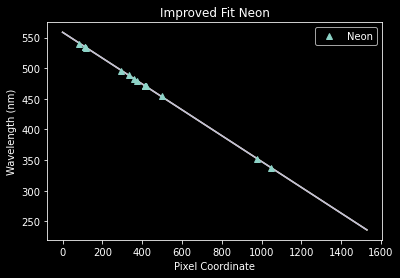

In [18]:
pl.plot(improved_xval_guesses_ne, ne_wl_final, '^', label='Neon')
#pl.plot(improved_xval_guesses, guessed_wavelengths, '+', label='Hydrogen')
pl.plot(xaxis, wavelengths, zorder=-5)
pl.plot(xaxis, linfit_wlmodel(xaxis), zorder=-5)
pl.legend(loc='best')
pl.xlabel("Pixel Coordinate")
pl.ylabel("Wavelength (nm)")
pl.title("Improved Fit Neon")

# Helium

In [19]:
he_keep1 = np.array(['*' not in x for x in helium_lines['Rel.']])
he_keep2 = (~helium_lines['Rel.'].mask)


In [20]:
he_keep = []
for i in range(len(he_keep1)):
    if he_keep2[i] == 1 & he_keep1[i] == 1:
        he_keep.append(1)
    else:
        he_keep.append(0)
he_keep = np.array(he_keep)

Text(0.5, 1.0, 'Helium and fit points')

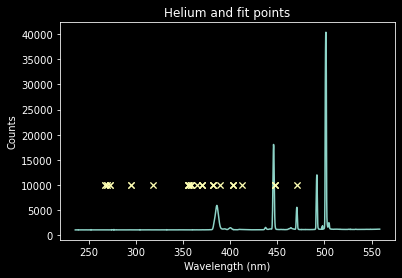

In [21]:
helium_lines['Rel.'] = helium_lines['Rel.'][he_keep]
he_keep_true = np.array(['*' not in x for x in helium_lines['Rel.']])
he_wl_tbl = helium_lines['Observed'][he_keep_true]
he_rel_tbl = np.array([float(x) for x in helium_lines['Rel.'][he_keep_true]])
he_rel_intens = he_rel_tbl / he_rel_tbl.max() * 10000
he_keep_final = he_rel_intens > 9999

pl.plot(wavelengths, he_spectrum)
pl.plot(he_wl_tbl[he_keep_final], he_rel_intens[he_keep_final], 'x')
pl.xlabel('Wavelength (nm)')
pl.ylabel("Counts")
pl.title("Helium and fit points")

In [22]:
he_wl_final = he_wl_tbl[he_keep_final]
he_pixel_vals = linfit_wlmodel.inverse(he_wl_final)

In [23]:
he_pixel_remove = (~he_pixel_vals.mask)
he_pixel_vals = he_pixel_vals[he_pixel_remove]
he_wl_remove = (~he_wl_final.mask)
he_wl_final = he_wl_final[he_wl_remove]

In [24]:
npixels = 5
improved_xval_guesses_he = [np.average(xaxis[g-npixels:g+npixels],
                                    weights=he_spectrum[g-npixels:g+npixels] - np.median(he_spectrum))
                         for g in map(int, he_pixel_vals)]
improved_xval_guesses_he

[1377.527808785869,
 1377.527808785869,
 1377.527808785869,
 1368.4418351887227,
 1368.4418351887227,
 1368.4418351887227,
 1355.5219680097184,
 1355.5219680097184,
 1355.5219680097184,
 1250.4292689781148,
 1250.4292689781148,
 1250.4292689781148,
 1135.6284480255517,
 1135.6284480255517,
 961.4451077570023,
 961.4451077570023,
 961.4451077570023,
 961.4451077570023,
 961.4451077570023,
 957.5559298675447,
 957.5559298675447,
 945.7919438787055,
 945.7919438787055,
 945.7919438787055,
 945.7919438787055,
 945.7919438787055,
 915.5162441823686,
 915.5162441823686,
 889.6807474874372,
 889.6807474874372,
 889.6807474874372,
 889.6807474874372,
 889.6807474874372,
 833.573891004512,
 833.573891004512,
 833.573891004512,
 833.573891004512,
 833.573891004512,
 804.00171565076,
 804.00171565076,
 739.4666863603405,
 739.4666863603405,
 739.4666863603405,
 739.4666863603405,
 739.4666863603405,
 692.9773147775722,
 692.9773147775722,
 529.3715041081102,
 529.3715041081102,
 529.3715041081102

Text(0.5, 1.0, 'Improved Helium Fit')

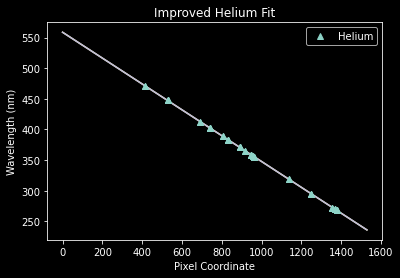

In [25]:
pl.plot(improved_xval_guesses_he, he_wl_final, '^', label='Helium')
pl.plot(xaxis, wavelengths, zorder=-5)
pl.plot(xaxis, linfit_wlmodel(xaxis), zorder=-5)
pl.legend(loc='best')
pl.xlabel("Pixel Coordinate")
pl.ylabel("Wavelength (nm)")
pl.title("Improved Helium Fit")

Text(0.5, 1.0, 'Helium Spectra Overlay')

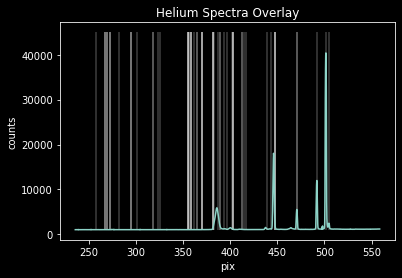

In [26]:
pl.plot(wavelengths, he_spectrum)
pl.vlines(helium_lines['Observed'], 1000, 45000, 'w', alpha=0.25);
pl.xlabel("pix")
pl.ylabel('counts')
pl.title('Helium Spectra Overlay')

# Hydrogen

In [27]:
h_keep = (~hydrogen_lines['Rel.'].mask) & (hydrogen_lines['Rel.'] != "700bl") & (hydrogen_lines['Rel.'] != "1100bl") & (hydrogen_lines['Rel.'] != "900bl") & (hydrogen_lines['Rel.'] != "1000bl") & (hydrogen_lines['Rel.'] != "1200bl")
h_wl_tbl = hydrogen_lines['Observed'][h_keep]
h_rel_tbl = np.array([float(x) for x in hydrogen_lines['Rel.'][h_keep]])

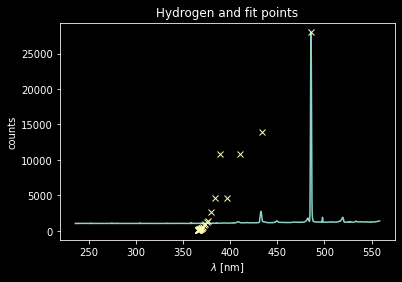

In [28]:
pl.plot(wavelengths, h_spectrum)
pl.plot(h_wl_tbl, h_rel_tbl / h_rel_tbl.max() * h_spectrum.max(), 'x')
pl.xlabel("$\lambda$ [nm]")
pl.ylabel("counts")
pl.title("Hydrogen and fit points");

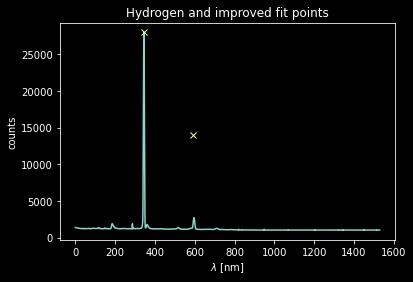

In [29]:
h_rel_intens =  h_rel_tbl / h_rel_tbl.max() * h_spectrum.max()
h_keep_final = h_rel_intens > 12500
h_wl_final = h_wl_tbl[h_keep_final]
h_pixel_vals = linfit_wlmodel.inverse(h_wl_final)

pl.plot(xaxis, h_spectrum)
pl.plot(h_pixel_vals, h_rel_intens[h_keep_final], 'x');
pl.xlabel("$\lambda$ [nm]")
pl.ylabel("counts")
pl.title("Hydrogen and improved fit points");

In [30]:
npixels = 15
improved_xval_guesses_h = [np.average(xaxis[g-npixels:g+npixels],
                                    weights=h_spectrum[g-npixels:g+npixels] - np.median(h_spectrum))
                         for g in map(int, h_pixel_vals)]
improved_xval_guesses_h

[593.817694714745, 344.59213802359596]

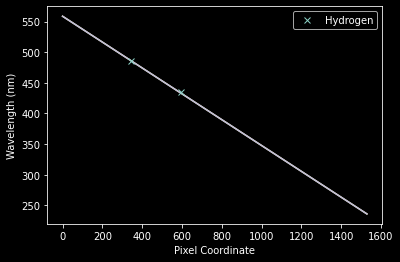

In [31]:
pl.plot(improved_xval_guesses_h, h_wl_final, 'x', label='Hydrogen')
pl.plot(xaxis, wavelengths, zorder=-5)
pl.plot(xaxis, linfit_wlmodel(xaxis), zorder=-5)
pl.legend(loc='best')
pl.xlabel("Pixel Coordinate")
pl.ylabel("Wavelength (nm)");

In [32]:
xvals_ne_plus_he_plus_h = list(improved_xval_guesses_ne) + list(improved_xval_guesses_he) + list(improved_xval_guesses_h)
waves_ne_plus_he_plus_h = list(ne_wl_final) + list(he_wl_final) + list(h_wl_final)
linfit_wlmodel_neheh = linfitter(model=wlmodel, x=xvals_ne_plus_he_plus_h, y=waves_ne_plus_he_plus_h)
linfit_wlmodel_neheh

<Linear1D(slope=-0.21125281, intercept=558.7217201)>

Text(0.5, 1.0, 'Best Wavelength Fit')

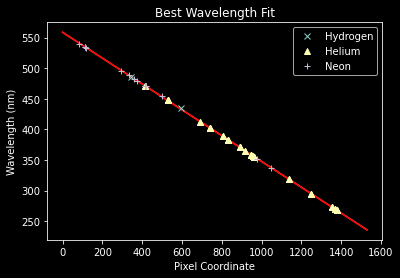

In [33]:
pl.plot(improved_xval_guesses_h, h_wl_final, 'x', label='Hydrogen')
pl.plot(improved_xval_guesses_he, he_wl_final, '^', label='Helium')
pl.plot(improved_xval_guesses_ne, ne_wl_final, '+', label='Neon')
pl.plot(xaxis, wavelengths, zorder=-5)
# Plotting the same thing but with the final wavelength solution!
pl.plot(xaxis, linfit_wlmodel_neheh(xaxis), zorder=-5, color='r')
pl.legend(loc='best')
pl.xlabel("Pixel Coordinate")
pl.ylabel("Wavelength (nm)");
pl.title("Best Wavelength Fit")

In [34]:
h_lam = np.median(h_wl_final)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [35]:
he_lam = np.median(he_wl_final)

In [36]:
ne_lam = np.median(ne_wl_final)

In [37]:
ne_wl_final

337.08749
352.1478
453.90268
470.57113
471.01769
471.13829
471.33817
471.66633
479.02645
482.86869
488.62812


In [104]:
D = 830 

In [105]:
ne_ang = np.arcsin(ne_lam/D)
ne_ang = ne_ang*u.rad
ne_ang.to(u.deg)

<Quantity 34.93917427 deg>

In [106]:
he_ang = np.arcsin(he_lam/D)
he_ang = he_ang*u.rad
he_ang.to(u.deg)

<Quantity 28.42949147 deg>

In [107]:
h_ang = np.arcsin(h_lam/D)
h_ang = h_ang*u.rad
h_ang.to(u.deg)

<Quantity 33.67504696 deg>